<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/neural_networks/GAN/StarGAN/stargan_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StarGAN

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [0]:
channels = 3
img_width = 128
img_height = 128
img_shape = (channels, img_width, img_height)
residual_blocks = 6

# wybrane atrybuty do zbioru danych CelebA
selected_attrs = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
c_dim = len(selected_attrs)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, in_features):
    super(ResidualBlock, self).__init__()

    conv_block = [
      nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
      nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
      nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
    ]

    self.conv_block = nn.Sequential(*conv_block)

  def forward(self, x):
    return x + self.conv_block(x)

In [0]:
class GeneratorResNet(nn.Module):
  def __init__(self, img_shape=(3, 128, 128), res_blocks=9, c_dim=5):
    super(GeneratorResNet, self).__init__()
    channels, img_size, _ = img_shape

    # Wstępny blok konwolucyjny
    model = [
      nn.Conv2d(channels + c_dim, 64, 7, stride=1, padding=3, bias=False),
      nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
      nn.ReLU(inplace=True)
    ]

    # Próbkowanie w dół
    curr_dim = 64
    for _ in range(2):
      model += [
        nn.Conv2d(curr_dim, curr_dim * 2, 4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(curr_dim* 2, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True),
      ]
      curr_dim *= 2

    # Pozostałe bloki
    for _ in range(res_blocks):
      model += [ResidualBlock(curr_dim)]

    # Próbkowanie w górę
    for _ in range(2):
      model += [
        nn.ConvTranspose2d(curr_dim, curr_dim // 2, 4, stride=2, padding=1, bias=False),
        nn.InstanceNorm2d(curr_dim // 2, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True),
      ]
      curr_dim = curr_dim // 2
    
    # Warstwa wyjściowa
    model += [nn.Conv2d(curr_dim, channels, 7, stride=1, padding=3), nn.Tanh()]

    self.model = nn.Sequential(*model)

  def forward(self, x, c):
    c = c.view(c.size(0), c.size(1), 1, 1)
    c = c.repeat(1, 1, x.size(2), x.size(3))
    x = torch.cat((x, c), 1)
    return self.model(x)

In [0]:
PATH_G = '/content/drive/My Drive/saved_models/generator_199.pth'
# PATH_D = '/content/drive/My Drive/saved_models/discriminator_199.pth'

In [8]:
model_G = GeneratorResNet(img_shape=img_shape, res_blocks=residual_blocks, c_dim=c_dim)
# model_D = Discriminator(img_shape=img_shape, c_dim=c_dim)

# Jeśli jesteśmy na GPU:
# model_G.load_state_dict(torch.load(PATH_G))

# Jeśli jesteśmy na CPU:
model_G.load_state_dict(torch.load(PATH_G, map_location=torch.device('cpu')))
# model_D.load_state_dict(torch.load(PATH_D, map_location=torch.device('cpu')))

# model_G.eval()

<All keys matched successfully>

In [0]:
import glob
import random
import os
import numpy as np
import torch

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [0]:
from PIL import Image
uploaded_img = Image.open('/content/drive/My Drive/uploaded_images/adam.png')

In [0]:
def get_tensor(uploaded_img):
  my_transforms = transforms.Compose([transforms.Resize((img_height, img_width), Image.BICUBIC),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
  return my_transforms(uploaded_img).unsqueeze(0)

In [0]:
tensor = get_tensor(uploaded_img)
#tensor.shape

In [0]:
# Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
Tensor = torch.FloatTensor

In [0]:
# Działa tylko dla selected_attrs = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']!

# (a, b)
# a      - indeks cechy w selected_attrs, do której się odwołujemy
# b = -1 - negacja 
# b = 0  - obojętność
# b = 1  - wystąpienie

label_changes = [
  ((0, 1),),  # Ustawienie czarnych włosów
  ((1, 1),),  # Ustawienie blond włosów
  ((2, 1),),  # Ustawienie brązowych włosów
  ((3, 1),),  # Zmiana płci
  ((4, 1),),  # Zmiana wieku
]

In [0]:
os.makedirs('produced_images', exist_ok=True)

In [0]:
"""

################
# PRODUCTION!! #
################

def generate_image(uploaded_img):
  prod_img = uploaded_img  # prod_img shape = [1, 3, 128, 128]
  prod_labels = torch.Tensor([[0, 0, 0, 0, 0]])  # prod_labels shape = [1, 5]

  img = prod_img[0]  # img shape = [3, 128, 128] 
  label = prod_labels[0]  # label shape = [5]
 
  imgs = img.repeat(c_dim, 1, 1, 1)  # imgs shape = [5, 3, 128, 128]
  labels = label.repeat(c_dim, 1)  # labels shape = [5, 5]

  for sample_i, changes in enumerate(label_changes):
    for col, val in changes:
      labels[sample_i, col] = 1 - labels[sample_i, col] if val == -1 else val
    
  gen_imgs = model_G(imgs, labels)
  img_sample = torch.cat((img.data, gen_imgs), -1)

  img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample), -2)

  save_image(img_samples.view(1, *img_samples.shape), 'produced_images/prod1.png', normalize=True)
  
  return gen_imgs
"""

In [0]:
"""Zapis wygenerowanej próbki"""
prod_imgs = tensor  # prod_img shape = [1, 3, 128, 128]
prod_labels = torch.Tensor([[0, 0, 0, 0, 0]])  # prod_labels shape = [1, 5]
img_samples = None

img, label = prod_imgs[0], prod_labels[0]
    
imgs = img.repeat(c_dim, 1, 1, 1)
labels = label.repeat(c_dim, 1)

for sample_i, changes in enumerate(label_changes):
  for col, val in changes:
    labels[sample_i, col] = 1 - labels[sample_i, col] if val == -1 else val

gen_imgs = model_G(imgs, labels)

gen_imgs = torch.cat([x for x in gen_imgs.data], -1)
img_sample = torch.cat((img.data, gen_imgs), -1)

img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample), -2)

save_image(img_samples.view(1, *img_samples.shape), 'produced_images/prod2.png', normalize=True)

In [32]:
print('prod_imgs:   {}'.format(prod_imgs.shape))
print('prod_labels: {}'.format(prod_labels.shape))
print('img:         {}'.format(img.shape))
print('label:       {}'.format(label.shape))
print('imgs:        {}'.format(imgs.shape))
print('labels:      {}'.format(labels.shape))
print('gen_imgs:    {}'.format(gen_imgs.shape))
print('img_sample:  {}'.format(img_sample.shape))
print('img_samples: {}'.format(img_samples.shape))

prod_imgs:   torch.Size([1, 3, 128, 128])
prod_labels: torch.Size([1, 5])
img:         torch.Size([3, 128, 128])
label:       torch.Size([5])
imgs:        torch.Size([5, 3, 128, 128])
labels:      torch.Size([5, 5])
gen_imgs:    torch.Size([3, 128, 640])
img_sample:  torch.Size([3, 128, 768])
img_samples: torch.Size([3, 128, 768])


In [24]:
imgs = torch.randn(5, 3, 128, 128)
labels = torch.randn(5, 5)

# labels = labels.view(labels.size(0), labels.size(1), 1, 1)
# labels = labels.repeat(1, 1, imgs.size(2), imgs.size(3))
# imgs = torch.cat((imgs, labels), 1)
print(labels.size(0))
print(labels.size(1))

5
5


In [25]:
labels = labels.view(labels.size(0), labels.size(1), 1, 1)
labels.shape

torch.Size([5, 5, 1, 1])

In [0]:
labels = labels.repeat(1, 1, imgs.size(2), imgs.size(3))

In [27]:
labels.shape

torch.Size([5, 5, 128, 128])

In [28]:
imgs = torch.cat((imgs, labels), 1)
imgs.shape

torch.Size([5, 8, 128, 128])

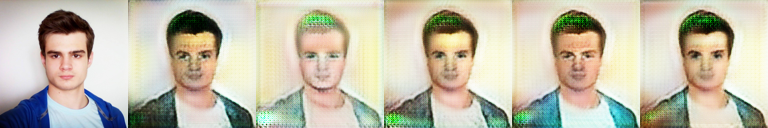

In [43]:
# label_changes = ((x, 1),)

prod_img = Image.open('produced_images/prod1.png')
prod_img

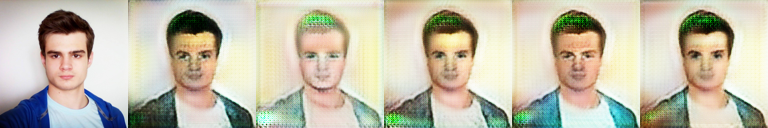

In [40]:
# label_changes = ((x, -1),)

prod_img = Image.open('produced_images/prod2.png')
prod_img